# Домашнее задание к занятию “Свёрточные сети”

Постройте модель, используя архитектуру со свёрточными слоями, для классификации Fashion MNIST. Итоговое качество (accuracy) должно быть не ниже 89,5.

Инструкция к выполнению задания

* Скачайте тренировочную и тестовою часть датасета Fashion MNIST
* Постройте архитектуру модели, используя свёрточные слои, слои регуляризации и один финальный полносвязный слой
* Обучите модель до необходимого качества. Если сеть не обучается до необходимого качества, попробуйте поменять архитектуру сети, варьируя параметры свёрток, количество каналов, количество свёрточных слоёв, слои регуляризации, тип оптимайзера и т. д.


### Импорт библиотек

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import torchvision as tv
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import time

### Загрузка данных

In [ ]:
BATCH_SIZE=128

In [ ]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 26421880/26421880 [00:01<00:00, 15936478.79it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272089.22it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5121177.54it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5867466.57it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



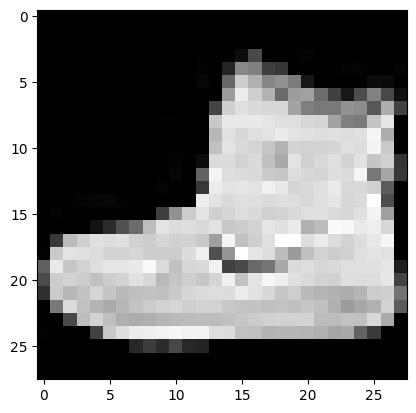

In [ ]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray');

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

### Создание класса

In [ ]:
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [ ]:
model = FashionCNN()
model.to(device)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [ ]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 600]       1,383,000
        Dropout2d-10                  [-1, 600]               0
           Linear-11                  [-1, 120]          72,120
           Linear-12                   [-1, 10]           1,210
Total params: 1,475,338
Trainable params: 1,475,338
Non-trainable params: 0
---------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


### Функция обучения

In [ ]:
def train_model():
    for ep in range(num_epochs):
        train_iters, train_passed  = 0, 0
        train_loss, train_acc = 0., 0.
        start=time.time()

        model.train()
        for X, y in train:
            X = X.to(device)
            y = y.to(device)
            trainer.zero_grad()
            y_pred = model(X)
            l = loss(y_pred, y)
            l.backward()
            trainer.step()
            train_loss += l.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()
            train_iters += 1
            train_passed += len(X)

        test_iters, test_passed  = 0, 0
        test_loss, test_acc = 0., 0.

        model.eval()
        for X, y in test:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            l = loss(y_pred, y)
            test_loss += l.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item()
            test_iters += 1
            test_passed += len(X)

        print("ep: {}, time: {:.3f}, train_loss: {}, train_acc: {}%, test_loss: {}, test_acc: {}%,".format(
            ep, time.time() - start, train_loss / train_iters, round(((train_acc/ train_passed)*100), 2),
            test_loss / test_iters, round(((test_acc/ test_passed)*100), 2))
        )

In [ ]:
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.99))

num_epochs = 10

In [ ]:
train_model()

ep: 0, time: 12.622, train_loss: 0.4802606465783455, train_acc: 83.36%, test_loss: 0.3642804460434974, test_acc: 87.19%,
ep: 1, time: 10.773, train_loss: 0.31325875175024653, train_acc: 88.84%, test_loss: 0.33035582549209835, test_acc: 88.41%,
ep: 2, time: 10.727, train_loss: 0.2735983311875797, train_acc: 90.18%, test_loss: 0.321505435282671, test_acc: 88.58%,
ep: 3, time: 10.774, train_loss: 0.2504070113812174, train_acc: 91.07%, test_loss: 0.3090363424035567, test_acc: 88.98%,
ep: 4, time: 10.634, train_loss: 0.233310168676539, train_acc: 91.63%, test_loss: 0.3076686566766304, test_acc: 89.08%,
ep: 5, time: 10.601, train_loss: 0.2187340111652417, train_acc: 92.19%, test_loss: 0.30495491831363003, test_acc: 89.19%,
ep: 6, time: 10.814, train_loss: 0.20730923143213492, train_acc: 92.66%, test_loss: 0.3012929185281826, test_acc: 89.48%,
ep: 7, time: 10.808, train_loss: 0.1970452362540434, train_acc: 93.03%, test_loss: 0.30701817902205863, test_acc: 89.61%,
ep: 8, time: 10.782, train_lo